# Project

During the semester, you will work on a project reading, understanding and implementing a model or inference method from an staff approved research paper. The deliverable is a Jupyter notebook tutorial containing a summary of the main ideas of the paper (with concrete pedagogical examples) and code implementing the main methods of the paper. You must work in a team of size 2 to 4 people.


# Project description



# Implementation

Our implementation mainly refer to the work of https://github.com/rka97/style_transfer.

We reserved the computer vision basics related part while implemented the optimization step ourselves.



In [1]:
import skimage.io as io
import cv2 as cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.color import rgb2gray
from numpy.linalg import eig
from numpy.linalg import multi_dot
import numpy as np
from sklearn.feature_extraction.image import extract_patches
from skimage.segmentation import chan_vese, morphological_chan_vese
from skimage.filters import gaussian
import math
from scipy.ndimage import binary_fill_holes
from skimage.morphology import watershed, disk, dilation
from sklearn.feature_extraction.image import extract_patches
from skimage.util import img_as_ubyte
from skimage.filters import rank
from scipy.spatial import Delaunay
from scipy import ndimage as ndi
from skimage.draw import polygon
from skimage.exposure import cumulative_distribution
from timeit import default_timer as timer
from skimage.util import view_as_windows, pad, random_noise
from sklearn.neighbors import NearestNeighbors
from skimage.segmentation import *
import collections

## Set Parameters

In [2]:
LMAX = 3
IM_SIZE = 400
PATCH_SIZES = np.array([33, 21, 13, 9, 5])
SAMPLING_GAPS = np.array([28, 18, 8, 5, 3])
IALG = 10
IRLS_it = 3
IRLS_r = 0.8
PADDING_MODE = 'edge'

In [247]:
content_img = 'empty.png'
style_img = 'van_gogh.jpg'

In [264]:
content = io.imread('images/'+content_img) / 255.0
content = content[:,:,:3]
style = io.imread('images/paper_images/' + style_img) / 255.0

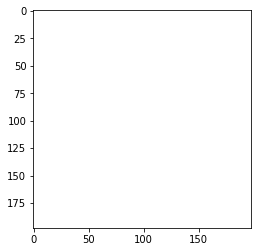

In [265]:
plt.imshow(content)

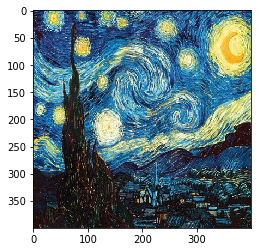

In [266]:
plt.imshow(style)

## Edge Segmentation

Detect the objects 

In [267]:
def gaussian_kernel(n):
    """
    derive a diagonal gaussian matrix kenel
    
    """
    # n must be odd number
    k = round((n - 1) / 2)  # n=2k+1 => k=(n-1)/2
    # generate a n*n gaussian kernel with mean=0 and sigma = s
    s = 1
    # create one vector of gaussian distribution
    probs = [np.exp(-z * z / (2 * s * s)) / np.sqrt(2 * np.pi * s * s) for z in range(-k, k + 1)]
    kernel = np.outer(probs, probs)  # construct 2d-gaussian kernel
    kernel = kernel.reshape(-1)  # vectorize it
    kernel = np.diag(kernel)  # make it diagonal matrix
    return kernel
def get_gradient(patch, n):
    """
    calculate derivatives of an image from x and y axis
    """
    gx = cv2.Sobel(np.float32(patch), cv2.CV_32F, 1, 0, ksize=n)
    gy = cv2.Sobel(np.float32(patch), cv2.CV_32F, 0, 1, ksize=n)
    G = np.stack((gx, gy), axis=-1)
    return G
def edge_detection(content, n=5, strength_threshold=0.04, coherence_threshold=0.5):
    """
    
    """
    content = rgb2gray(content)
    W = gaussian_kernel(n)

    G = get_gradient(content, n)
    patches = extract_patches(G, patch_shape=(n, n, 2), extraction_step=1)
    patches = patches.reshape((-1, n**2, 2))

    l = list(patches)
    img = np.zeros((len(l)))
    GWG = [multi_dot([Gk.T, W, Gk]) for Gk in l]

    eigen = [eig(GWGi) for GWGi in GWG]
    e_val, e_vect = zip(*eigen)
    e_val = np.asarray(e_val, dtype=np.float64)
    e_vect = np.asarray(e_vect, dtype=np.float64)
    for k in range(0, len(eigen)):
        if e_val[k][0] > e_val[k][1]:
            largest = 0  # indx, = np.where(e_val == largest_lambda)
        else:
            largest = 1
        x, y = e_vect[k][largest, 0], e_vect[k][largest, 1]  # e_vect corresponding to largest e_val
        if x != 0:
            angle = math.degrees(math.atan(y / x))
        else:
            angle = 90
        strength = math.sqrt(e_val[k][largest])

        dominator = float(np.sqrt(e_val[k][largest]) + np.sqrt(e_val[k][1 - largest]))
        if dominator != 0:
            coherent = (np.sqrt(e_val[k][largest]) - np.sqrt(e_val[k][1 - largest])) / dominator
        if strength >= strength_threshold and coherent >= coherence_threshold:
            img[k] = strength
    img = img.reshape(int(np.sqrt(patches.shape[0])), int(np.sqrt(patches.shape[0])))
    return img

def edge_segmentation(
    img, strength_threshold=8, coherence_threshold=0.5, mode=4,
    ch_ethreshold=0.8,
    ws_ethreshold=0.2, ws_mdisk_size=5, ws_mthreshold=20, ws_gdisk_size=2, ws_glevel_threshold=4,
    cv_ethreshold=0, cv_mu=0.1, cv_lamda_1=0.06, cv_lamda_2=1, cv_tol=1e-3, cv_max_iter=2000, cv_dt=0.52, cv_init_level_set="checkerboard",
    mcv_init_level_set="edges", mcv_c1=1.0, mcv_c2=1.0, mcv_max_iter=35, mcv_smoothing=1, mcv_sigma=5
):
    IM_SIZE = 400
    img = (cv2.resize(img, (IM_SIZE, IM_SIZE))).astype(np.float32)
    root_n = 5
    edges = edge_detection(img, root_n, strength_threshold=strength_threshold, coherence_threshold=coherence_threshold)  # root_n should be odd number #8-0.5
    final_image = np.zeros((img.shape[0], img.shape[1]))
    if mode == 0:
        # thresholding edges for convex hull with threshold to remove as much noise as possible
        edges[edges >= ch_ethreshold] = 1
        edges[edges < ch_ethreshold] = 0
        chull = convex_hull(edges)
        final_image[:chull.shape[0], :chull.shape[1]] = chull
        return final_image
    elif mode == 1:
        # thresholding edges for watershed on edges with low threshold to include as much edges as possible
        edges[edges >= ws_ethreshold] = 1
        edges[edges < ws_ethreshold] = 0
        watershed_edges_bin = watershed_edges(edges)
        final_image[:watershed_edges_bin.shape[0], :watershed_edges_bin.shape[1]] = watershed_edges_bin
        return final_image
    elif mode == 2:
        edge_chull = edges
        edge_watershed = edge_chull.copy()

        # thresholding edges for convex hull with threshold to remove as much noise as possible
        edge_chull[edge_chull >= ch_ethreshold] = 1
        edge_chull[edge_chull < ch_ethreshold] = 0
        # thresholding edges for watershed on edges with low threshold to include as much edges as possible
        edge_watershed[edge_watershed >= ws_ethreshold] = 1
        edge_watershed[edge_watershed < ws_ethreshold] = 0

        chull = convex_hull(edge_chull)
        watershed_edges_bin = watershed_edges(edge_watershed, ws_mdisk_size, ws_mthreshold, ws_gdisk_size, ws_glevel_threshold)
        watershed_cull = chull * watershed_edges_bin[:chull.shape[0], :chull.shape[1]]
        final_image[:watershed_cull.shape[0], :watershed_cull.shape[1]] = watershed_cull
        return final_image
    elif mode == 3:
        # Feel free to play around with the parameters to see how they impact the result
        edges[edges != cv_ethreshold] = 1

        cv_init_level_set = cv_init_level_set.split(',')
        cv_init_level = cv_init_level_set[0]
        if cv_init_level_set[0] == "edges":
            cv_init_level = edges
        elif cv_init_level_set[0] == "original gray":
            cv_init_level = rgb2gray(img)
            cv_init_level = cv_init_level[:edges.shape[0], :edges.shape[1]]
        elif cv_init_level_set[0] == "path":
            cv_init_level = io.imread(cv_init_level_set[1])
            cv_init_level = (cv2.resize(cv_init_level, (IM_SIZE, IM_SIZE))).astype(np.float32)
            cv_init_level = rgb2gray(cv_init_level)
            cv_init_level = cv_init_level[:edges.shape[0], :edges.shape[1]]

        cv = chan_vese(edges, mu=cv_mu, lambda1=cv_lamda_1, lambda2=cv_lamda_2, tol=cv_tol, max_iter=cv_max_iter,
                       dt=cv_dt, init_level_set=cv_init_level)

        mask = cv
        final_image[:mask.shape[0], :mask.shape[1]] = mask
        return final_image
    else:
        E = np.zeros((img.shape[0], img.shape[1]))
        E[:edges.shape[0], :edges.shape[1]] = edges

        mcv_init_level_set = mcv_init_level_set.split(',')
        mcv_init_level = mcv_init_level_set[0]
        if mcv_init_level_set[0] == "edges":
            mcv_init_level = E
        elif mcv_init_level_set[0] == "original gray":
            mcv_init_level = rgb2gray(img)
        elif mcv_init_level_set[0] == "path":
            mcv_init_level = io.imread(mcv_init_level_set[1])
            mcv_init_level = (cv2.resize(mcv_init_level, (IM_SIZE, IM_SIZE))).astype(np.float32)
            mcv_init_level = rgb2gray(mcv_init_level)

        mask = mcv_c1 * (gaussian(mcv_c2 * E + morphological_chan_vese(rgb2gray(img), iterations=mcv_max_iter, init_level_set=mcv_init_level, smoothing=mcv_smoothing), sigma=mcv_sigma))
        return mask

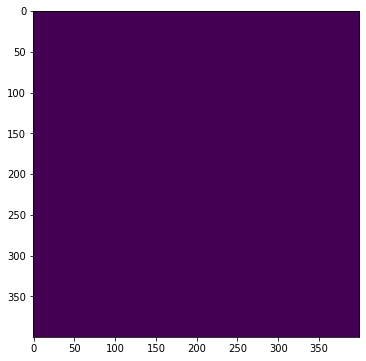

In [268]:
segm_mask = edge_segmentation(content, 5, 0.6)
plt.figure(figsize = (6,6))
plt.imshow(segm_mask)
plt.show()

In [269]:
segm_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [270]:
content = (cv2.resize(content, (IM_SIZE, IM_SIZE))).astype(np.float32)
style = (cv2.resize(style, (IM_SIZE, IM_SIZE))).astype(np.float32)
segm_mask = (cv2.resize(segm_mask, (IM_SIZE, IM_SIZE))).astype(np.float32)

## Color transfer

Applying color-transfer from the style to the content within the iterative process, in order to preserve the richness of the style in the final outcome and avoid repetitive patterns, and perhaps the most important
of all

In [271]:
# color transfer with histogram matching using interpolation
def color_transfer(content, style):
    transfered = np.copy(content)
    # for each channel of the content, match the cum_histogram with the style's one
    for i in range(0, content.shape[2]):
        content_channel = content[:, :, i].flatten()
        style_channel = style[:, :, i].flatten()
        # calculate histogram for both content and style
        content_values, content_indices, content_counts = \
        np.unique(content_channel, return_inverse=True, return_counts=True)
        style_values, style_counts = np.unique(style_channel, return_counts=True)
        # calculate cummulative histogram
        content_cumhist = np.cumsum(content_counts)
        style_cumhist = np.cumsum(style_counts)
        # normalize it
        content_cumhist = content_cumhist / np.max(content_cumhist)
        style_cumhist = style_cumhist / np.max(style_cumhist)
        # match using interpolation
        matched = np.interp(content_cumhist, style_cumhist, style_values)
        transfered[:, :, i] = matched[content_indices].reshape(content[:, :, i].shape)
    return transfered

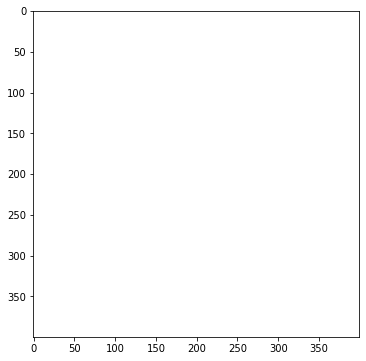

In [281]:
content = color_transfer(content, style)
plt.figure(figsize = (6,6))
plt.imshow(content)
plt.show()

## Style Transfer

### PCA

In [273]:
def means_mat(mat):
    means = np.sum(mat, axis=0) / mat.shape[0]
    means = np.matmul(np.ones((mat.shape[0], 1)), np.transpose(means.reshape(mat.shape[1], 1)))
    return means


def covariance_mat(mat):
    # removing mean to make the data with zero means so it varies around the origion
    means = means_mat(mat)
    mat = mat - means
    cov_mat = np.cov(mat.T)

    return cov_mat


def projection_mat(mat):
    new_mat = mat.copy()

    # creating covarianve matrix to perform get its eigen values and eigen vectors
    covariance_matrix = covariance_mat(new_mat)

    # eigenvectors and eigenvalues of the covariance matrix
    eig_val_cov, eig_vec_cov = np.linalg.eig(covariance_matrix)

    # creating a dectionary of eigen values and egen vectors to order them respeactivly
    eig_val_vec = {}
    for i in range(eig_val_cov.shape[0]):
        eig_val_vec[eig_val_cov[i]] = eig_vec_cov[:, i]

    # ordering eigen values in decending order
    eig_val_vec = dict(collections.OrderedDict(sorted(eig_val_vec.items(), reverse=True)))

    i = 0
    for key in eig_val_vec:
        eig_val_cov[i] = key
        eig_vec_cov[:, i] = eig_val_vec[key]
        i = i + 1

    # normlizing eigen values
    eig_val_cov = eig_val_cov / np.sum(eig_val_cov)

    k = 0
    summation = 0
    for i in range(0, eig_val_cov.shape[0]):
        if summation >= 0.95:
            break
        k = k + 1
        summation = summation + eig_val_cov[i]

    ep = np.zeros((k, new_mat.shape[1]))
    for i in range(k):
        ep[i] = eig_vec_cov[:, i].real

    return ep


def pca(mat):
    new_mat = mat.copy()
    ep = projection_mat(new_mat)
    new_mat = new_mat - means_mat(new_mat)
    output = (np.matmul(ep, new_mat.T)).T
    return (output, ep)

def project(mat, ep):
    new_mat = mat.copy()
    new_mat = new_mat - means_mat(new_mat)
    return (np.matmul(ep, new_mat.T)).T

### Style transfer
An initialization of the algorithm by the content image, augmented by very strong noise, in order to both tie the result to the content in selected areas, while enabling it to depart from it elsewhere.

Merging the intermediate result with the content image in selected areas, applied in the patch-aggregation step in each iteration. This is based on a segmentation algorithm that defines the importance of content regions.

In [274]:
# img: RGB image to apply the filter t.
# abs_der: | d/dx (img(x)) |
# J[n] = I[n] + a^d (J[n-1] - I[n])
def recursive_filter(img, abs_der, h):
    im = np.copy(img)
    a = np.exp(-1 * np.sqrt(2) / h)
    var = np.power(a, abs_der)
    l, m, n = img.shape
    for i in range(1, m):
        for j in range(n):
            im[:, i, j] = img[:, i, j] + np.multiply(var[:, i], (im[:, i - 1, j] - img[:, i, j]))
    for i in range(m - 2, 0, -1):
        for j in range(n):
            im[:, i, j] = img[:, i, j] + np.multiply(var[:, i + 1], (im[:, i + 1, j] - img[:, i, j]))
    return im

# img: the image to denoise.
# sigma_r: controls variance over the signal's range.
# sigma_s: controls variance over the signal's spatial domain.
# denoises img through applying the domain transform then a RecursiveFilter. Returns denoised image.
def denoise(img, sigma_r=0.77, sigma_s=40):
    l, m, n = img.shape
    # using finite diffrence to get partial derivative
    dIdx = np.abs(np.diff(img, 1, 1))  # diff(A,1,1) works on successive elements in the columns of A and returns a p-by-(m-1) difference matrix.
    dIdy = np.abs(np.diff(img, 1, 0))  # diff(A,1,2) works on successive elements in the rows of A and returns a (p-1)-by-m difference matrix.
    derx = np.zeros((l, m))
    dery = np.zeros((l, m))
    derx[:, 1:m] = np.sum(dIdx, axis=2)
    dery[1:l, :] = np.sum(dIdy, axis=2)
    # horizontal and vertical derivatives
    dhdx = (1 + sigma_s / sigma_r * derx)
    dvdy = np.transpose((1 + sigma_s / sigma_r * dery))
    # to get ct, we integrate, not needed in case of using the recursive filter
    # cth = np.cumsum(dhdx,2)
    # ctv = np.cumsum(dvdy,1)
    const = sigma_s * np.sqrt(3) / np.sqrt(4**3 - 1)
    t_img = np.copy(img)
    for i in range(3):  # 3 is the no of iterations usually used, we could change it
        sigma_h = const * 2**(3 - i - 1)
        t_img = recursive_filter(t_img, dhdx, sigma_h)
        t_img = np.transpose(t_img, axes=(1, 0, 2))  # (m,l,n)
        t_img = recursive_filter(t_img, dvdy, sigma_h)
        t_img = np.transpose(t_img, axes=(1, 0, 2))  # (l, m, n)
    return t_img


def build_gaussian_pyramid(img, L):
    img_arr = []
    img_arr.append(img)  # D_L (img) = img
    for i in range(L - 1):
        img_arr.append(cv2.pyrDown(img_arr[-1].astype(np.float32)).astype(np.float32))
    return img_arr

def solve_irls(X, X_patches_raw, p_index, style_patches, neighbors, projection_matrix):
    p_size = PATCH_SIZES[p_index]
    sampling_gap = SAMPLING_GAPS[p_index]
    current_size = X.shape[0]
    # Extracting Patches
    X_patches = X_patches_raw.reshape(-1, p_size * p_size * 3)
    npatches = X_patches.shape[0]
    if p_size <= 21:
        X_patches = project(X_patches, projection_matrix)  # Projecting X to same dimention as style patches
    # Computing Nearest Neighbors
    distances, indices = neighbors.kneighbors(X_patches)
    distances += 0.0001
    weights = np.power(distances, IRLS_r - 2)
    # Patch Accumulation
    R = np.zeros((current_size, current_size, 3), dtype=np.float32)
    Rp = extract_patches(R, patch_shape=(p_size, p_size, 3), extraction_step=sampling_gap)
    X[:] = 0
    t = 0
    for t1 in range(X_patches_raw.shape[0]):
        for t2 in range(X_patches_raw.shape[1]):
            nearest_neighbor = style_patches[indices[t, 0]]
            X_patches_raw[t1, t2, 0, :, :, :] += nearest_neighbor* weights[t]
            Rp[t1, t2, 0, :, :, :] += 1 * weights[t]
            t = t + 1
    R += 0.0001  # to avoid dividing by zero.

In [275]:
segmentation_mask = segm_mask
sigma_r=0.17;sigma_s=15

In [279]:
def KNN(style_patches):
    """
    this function is used to find nearest neighbor in content image corresponding 
    to the patch in style images
    """
    style_patches_arr = style_patches.reshape(-1,p_size*p_size*3)
    neighbors = NearestNeighbors(n_neighbors=1).fit(style_patches_arr)
    return style_patches_arr,neighbors

def update_X(X, X_patches,style_patches_arr,neighbors):
    X_patches_arr = X_patches.reshape(-1, p_size*p_size*3)
    distances, indices = neighbors.kneighbors(X_patches_arr)
    distances += 0.001
    weights = np.power(distances,IRLS_r - 2)
    D = np.zeros(X.shape)
    Dp = extract_patches(D, patch_shape=(p_size, p_size, 3), \
                                        extraction_step=SAMPLING_GAPS[n])
    p = 0
    X_patches[:] = 0
    for i in range(X_patches.shape[0]):
        for j in range(X_patches.shape[1]):
            style_fill = style_patches_arr[indices[p][0],:].reshape(p_size, p_size, 3)
            X_patches[i,j,0,:,:] += weights[p]*style_fill
            Dp[i,j,0,:,:,:] += weights[p]
            p+=1
    D += 0.001 #avoid 0
    X /= D
            

Starting Style Transfer..
Scale  2
Patch Size 33


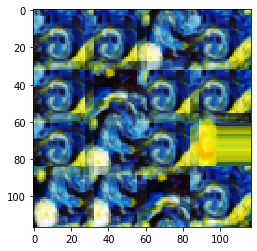

Patch Size 21


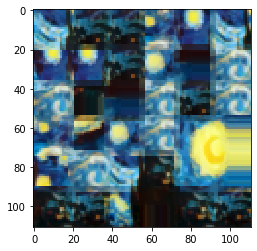

Patch Size 13


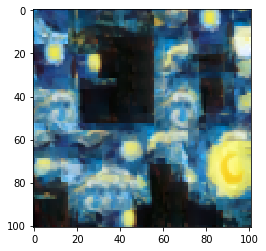

Patch Size 9


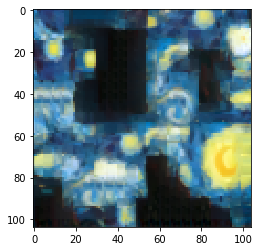

Patch Size 5


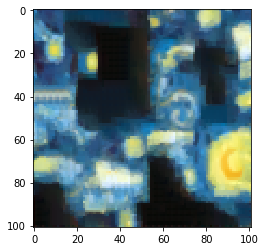

Scale  1
Patch Size 33


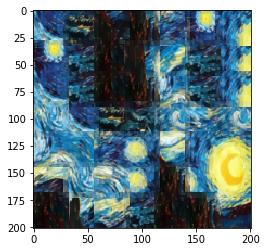

Patch Size 21


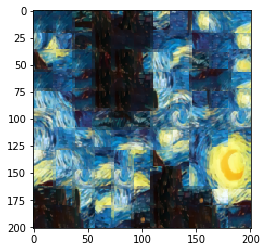

Patch Size 13


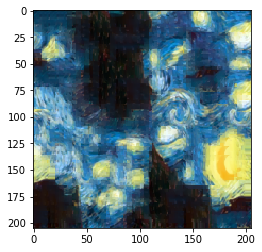

Patch Size 9


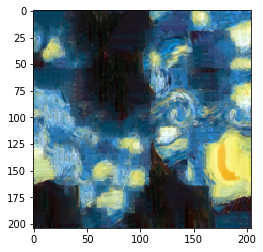

Patch Size 5


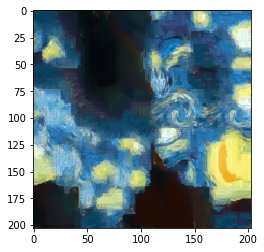

Scale  0
Patch Size 33


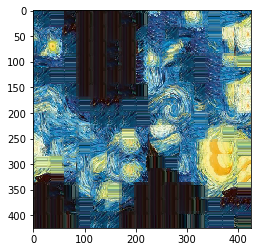

Patch Size 21


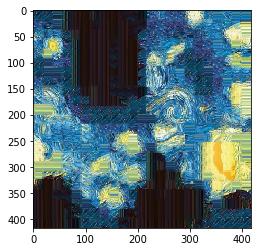

Patch Size 13


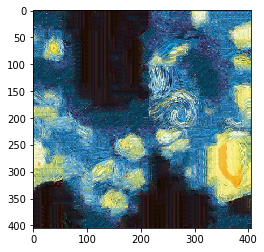

Patch Size 9


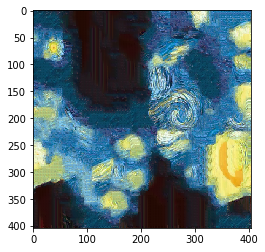

Patch Size 5


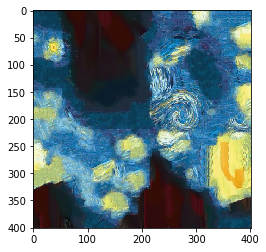

In [280]:
#Set up Content Fusion constants.
#down sample for LMAX times
content_arr = build_gaussian_pyramid(content, LMAX) 
style_arr = build_gaussian_pyramid(style, LMAX)
segm_arr = build_gaussian_pyramid(segmentation_mask, LMAX) #segmentation mask

# Initialize X with the content + strong noise.
X = random_noise(content_arr[LMAX - 1], mode='gaussian', var=50)
fus_const1 = []
fus_const2 = []
for i in range(LMAX):
    sx, sy = segm_arr[i].shape
    curr_segm = segm_arr[i].reshape(sx, sy, 1) 
    fus_const1.append(curr_segm * content_arr[i]) #(W*C)
    fus_const2.append(1.0 / (curr_segm + 1)) #(W+I)^-1
print('Starting Style Transfer..')

for L in range(LMAX - 1, -1, -1):  # over scale L
    print('Scale ', L)
    current_size = style_arr[L].shape[0]
    style_L_sx, style_L_sy, _ = style_arr[L].shape
    X = random_noise(X, mode='gaussian', var=20 / 250.0)
    #patch matching 
    for n in range(PATCH_SIZES.size):  # over patch size n
        p_size = PATCH_SIZES[n]
        print('Patch Size', p_size)
        npatchx = int((style_L_sx - p_size) / SAMPLING_GAPS[n] + 1)	
        # The images are padded to avoid side artifacts.
        padding = p_size - (style_L_sx - npatchx * SAMPLING_GAPS[n])
        padding_arr = ((0, padding), (0, padding), (0, 0))
        current_style = pad(style_arr[L], padding_arr, mode=PADDING_MODE)
        X = pad(X, padding_arr, mode=PADDING_MODE)
        X_patches =  extract_patches(X,  patch_shape=(p_size, p_size, 3), \
                                        extraction_step=SAMPLING_GAPS[n])
    
        const1 = pad(fus_const1[L], padding_arr, mode=PADDING_MODE)
        const2 = pad(fus_const2[L], padding_arr, mode=PADDING_MODE)
        
        #style_patches: neighbors(Q) = argmin||RX-QS||
        style_patches = extract_patches(current_style,  patch_shape=(p_size, p_size, 3), \
                                        extraction_step=SAMPLING_GAPS[n])
        
        style_patches_arr,neighbors = KNN(style_patches)
        
        for k in range(IALG):
            # Steps 1 & 2: Patch-Extraction and and Robust Patch Aggregation
            #(X_patches_raw = RX)
            for i in range(IRLS_it):
                X_patches = extract_patches(X,  patch_shape=(p_size, p_size, 3), \
                                        extraction_step=SAMPLING_GAPS[n])
                update_X(X, X_patches,style_patches_arr,neighbors)
            
            X = const2 * (X + const1) 
            # Step 4: Color Transfer
            X = color_transfer(X, style)
            # Step 5: Denoising
            X[:style_L_sx, :style_L_sx, :] = denoise(X[:style_L_sx, :style_L_sx, :], sigma_r=sigma_r, sigma_s=sigma_s)
        plt.imshow(X)
        plt.show()
        X = X[:style_L_sx, :style_L_sx, :]  # Discard padding.
        

    # Upscale X
    if (L > 0):
        sizex, sizey, _ = content_arr[L - 1].shape
        X = cv2.resize(X, (sizex, sizey))



In [190]:
from scipy.optimize import minimize
def train(X, X_patches_raw, p_index, style_patches, neighbors, projection_matrix):
    
    p_size = PATCH_SIZES[p_index]
    sampling_gap = SAMPLING_GAPS[p_index]
    current_size = X.shape[0]
    # Extracting Patches
    X_patches = X_patches_raw.reshape(-1, p_size * p_size * 3)
    npatches = X_patches.shape[0]
    if p_size <= 21:
        X_patches = project(X_patches, projection_matrix)  # Projecting X to same dimention as style patches
    # Computing Nearest Neighbors
    distances, indices = neighbors.kneighbors(X_patches)
    distances += 0.0001
    # Computing Weights
    weights = np.power(distances, IRLS_r - 2)

    xp1,xp2 = X_patches.shape
    
    R = np.zeros((len(indices) ,len(X_patches)))
    W = np.eye(len(X_patches))
    for i,x in enumerate(indices):
        R[i,x[0]] = 1
        W[i,i] = weights[i]
    #mask = (1- segm_patches/np.max(segm_patches))
        
    
    def loss(X_patches):
        
        X_patches = X_patches.reshape(xp1,xp2)
            
        dists = np.power(np.linalg.norm(np.dot(R,X_patches) - curr_style, axis = 1),2).reshape(len(W),-1)  
        style_loss = np.sum(np.dot(W, dists))
        
        #content_loss =  np.sum(np.power(np.linalg.norm(mask* \
        #                         (X_patches -content_patches), axis = 1),2))
                      
        ans = style_loss
       
        return ans
    
   
    opt = minimize(loss, X_patches,method = 'tnc').x
    print(loss(opt))
        
    X_patches[:,:] = opt.reshape(xp1,xp2)
    

    #return X_patches
        
    